In [1]:
import numpy as np
import pickle
import pandas as pd
import os
from os.path import join
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score
from scipy import stats
import xgboost as xgb
from hyperopt import fmin, rand, hp, Trials, tpe
# rstate = np.random.default_rng(42)
import random
# random.set_seed(10)

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl

datasets_dir = "../../data"
# plt.style.use('CCB_plot_style_0v4.mplstyle')
# c_styles      = mpl.rcParams['axes.prop_cycle'].by_key()['color']   # fetch the defined color styles
# high_contrast = ['#004488', '#DDAA33', '#BB5566', '#000000']

## Loading training and test data:

In [2]:
split = "secondary"

data_train = pd.read_pickle(join(datasets_dir, "splits", split, "training_data.pkl"))
data_test = pd.read_pickle(join(datasets_dir, "splits", split, "test_data.pkl"))
data_val = pd.read_pickle(join(datasets_dir, "splits", split, "val_data.pkl"))

# data_train["geomean_kcat"] = np.log10(data_train["geomean_kcat"])
# data_test["geomean_kcat"] = np.log10(data_test["geomean_kcat"])

data_train["log10_kcat"] = np.log10(data_train["kcat"])
data_test["log10_kcat"] = np.log10(data_test["kcat"])
data_val["log10_kcat"] = np.log10(data_val["kcat"])

data_train.rename(columns = {"Enzyme rep" : "ESM2"}, inplace = True)
data_test.rename(columns = {"Enzyme rep" : "ESM2"}, inplace = True)
data_val.rename(columns = {"Enzyme rep" : "ESM2"}, inplace = True)

data_train['Temperature'] = data_train['Temperature'].replace('-', np.nan)
data_test['Temperature'] = data_test['Temperature'].replace('-', np.nan)
data_val['Temperature'] = data_val['Temperature'].replace('-', np.nan)
data_train['pH'] = data_train['pH'].replace('-', np.nan)
data_test['pH'] = data_test['pH'].replace('-', np.nan)
data_val['pH'] = data_val['pH'].replace('-', np.nan)
data_train['Type'] = data_train['Type'].replace('wildtype', 1)
data_train['Type'] = data_train['Type'].replace('mutant', 2)
data_test['Type'] = data_test['Type'].replace('wildtype', 1)
data_test['Type'] = data_test['Type'].replace('mutant', 2)
data_val['Type'] = data_val['Type'].replace('wildtype', 1)
data_val['Type'] = data_val['Type'].replace('mutant', 2)

data_train['MACCS FP'] = data_train['MACCS FP'].astype(str)
data_test['MACCS FP'] = data_test['MACCS FP'].astype(str)
data_val['MACCS FP'] = data_val['MACCS FP'].astype(str)

len(data_train), len(data_test), len(data_val)

(105, 36, 7)

In [3]:
train_indices = list(np.load(join(datasets_dir, "splits", split, "CV_train_indices_Seed plants.npy"), allow_pickle = True))
test_indices = list(np.load(join(datasets_dir, "splits", split, "CV_test_indices_Seed plants.npy"), allow_pickle = True))

In [4]:
data_test = data_test[~data_test['GNN FP'].isnull()]

nan_rows = data_train[data_train['GNN FP'].apply(lambda x: not isinstance(x, np.ndarray))]

# Get the indices of these rows
indices_with_nan = nan_rows.index.tolist()
# indices_with_nan.reverse()
print(indices_with_nan)

for ind, sub_list in enumerate(train_indices):
    for elem in sub_list:
        if elem in indices_with_nan:
            sub_list.remove(elem)

for ind, sub_list in enumerate(train_indices):
    for num in indices_with_nan:
        for i, elem in enumerate(sub_list):
            if elem > num:
                train_indices[ind][i] = elem-1

for ind, sub_list in enumerate(test_indices):
    for elem in sub_list:
        if elem in indices_with_nan:
            sub_list.remove(elem)

for ind, sub_list in enumerate(test_indices):
    for num in indices_with_nan:
        for i, elem in enumerate(sub_list):
            if elem > num:
                test_indices[ind][i] = elem-1  


data_train = data_train[data_train['GNN FP'].apply(lambda x: isinstance(x, np.ndarray))]
data_train.reset_index(inplace=True, drop=True)

[]


## 1. Training a model with enzyme and substrate information (ESM-2/MACCS) + Temperature + pH:

#### (a) Creating input matrices:

In [ ]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [ ]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
#     print(param)
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     print(-np.mean(R2))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.quniform("learning_rate", 0.01, 0.2, 0.1),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.quniform("num_rounds", 100, 1000, 250)
#     }

# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 10, trials=trials, return_argmin=False)

# print(best)
# param = best
# param["random_state"] = 42

In [ ]:
# results = []

# param_grid = {'learning_rate': [0.01,0.1,0.2],
#                 'max_depth': [3,4,5,6,7,8,9,10],
#                 'reg_lambda': [0, 0.2,0.4,0.6,0.8,1],
#                 'reg_alpha': [0, 0.2,0.4,0.6,0.8,1],
#                 'max_delta_step' : [1,2,3,4,5],
#                 'min_child_weight': [1,2,3,4,5,6],
#                 'num_rounds': [100,250,500,1000]}

# params_list = [(learning_rate, max_depth, reg_lambda, reg_alpha, max_delta_step, min_child_weight, num_rounds) for learning_rate in param_grid['learning_rate'] for max_depth in param_grid["max_depth"] for reg_lambda in param_grid['reg_lambda']
#                 for reg_alpha in param_grid['reg_alpha'] for max_delta_step in param_grid['max_delta_step'] for min_child_weight in param_grid['min_child_weight'] for num_rounds in param_grid["num_rounds"]]

# params_list = random.sample(params_list, 10)

# for param in params_list:
#     params = {}
#     params["learning_rate"], params["max_depth"], params["reg_lambda"], params["reg_alpha"], params["max_delta_step"], params["min_child_weight"], params["num_rounds"] = param
#     R2 = cross_validation_mse_gradient_boosting(params)
#     results.append({"learning_rate" : params["learning_rate"], "max_depth" : params["max_depth"] , "reg_lambda" : params["reg_lambda"], "reg_alpha" : params["reg_alpha"],
#                 "max_delta_step" : params["max_delta_step"], "min_child_weight" : params["min_child_weight"], "num_rounds" : params["num_rounds"], "cv_R2" : R2})

# params = min(results, key=lambda d: d['cv_R2'])
# print(params)

In [ ]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 5.0, 'max_depth': 5.0, 'min_child_weight': 2.0, 'num_rounds': 750.0, 'reg_alpha': 0.6, 'reg_lambda': 0.6}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 2.0, 'num_rounds': 500.0, 'reg_alpha': 1.0, 'reg_lambda': 0.0}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 1.0, 'max_depth': 3.0, 'min_child_weight': 5.0, 'num_rounds': 1000.0, 'reg_alpha': 0.4, 'reg_lambda': 0.4}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 1.0, 'max_depth': 3.0, 'min_child_weight': 2.0, 'num_rounds': 500.0, 'reg_alpha': 0.8, 'reg_lambda': 1.0}
else:
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 5.0, 'max_depth': 7.0, 'min_child_weight': 5.0, 'num_rounds': 250.0, 'reg_alpha': 0.4, 'reg_lambda': 1.0}


#### (c) Training and validating model:

In [ ]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [ ]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_EMS2_gnn_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_EMS2_gnn_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_EMS2_gnn_fp.npy"), np.array(R2))

In [ ]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))
# MedAE = np.median(abs(np.array(test_Y) - np.array(y_test_pred)))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))

np.save(join("..", "..", "data", "y_test_pred_xgboost_EMS2_gnn_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_EMS2_gnn_fp.npy"), test_Y)

In [ ]:
y_test_pred_esm1b_ts_drfp = y_test_pred

In [ ]:
pd.DataFrame(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))).describe()

#### (d) Training model with test and train data for production mode:

In [ ]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [ ]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

##### Validating model

In [ ]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["GNN FP"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

In [ ]:
dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

## 2. Training a model with enzyme and reaction information (ESM-2/diff_fp) + Temperature + pH:

#### (a) Creating input matrices:

In [ ]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [ ]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.quniform("learning_rate", 0.01, 0.2, 0.1),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.quniform("num_rounds", 100, 1000, 250)
#     }

# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 10, trials=trials, return_argmin=False)

# print(best)
# param = best
# param["random_state"] = 42

In [ ]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 5.0, 'num_rounds': 750.0, 'reg_alpha': 0.8, 'reg_lambda': 1.0}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4.0, 'max_depth': 4.0, 'min_child_weight': 2.0, 'num_rounds': 500.0, 'reg_alpha': 0.4, 'reg_lambda': 0.6}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 750.0, 'reg_alpha': 0.4, 'reg_lambda': 0.4}
elif split == "wildtype":
    param = {"random_state": 42,'learning_rate': 0.1, 'max_delta_step': 4.0, 'max_depth': 3.0, 'min_child_weight': 3.0, 'num_rounds': 1000.0, 'reg_alpha': 1.0, 'reg_lambda': 1.0}
else:
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 750.0, 'reg_alpha': 0.4, 'reg_lambda': 0.4}

#### (c) Training and validating model:

In [ ]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [ ]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_EMS2_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_EMS2_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_EMS2_diff_fp.npy"), np.array(R2))

In [ ]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)
MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))

np.save(join("..", "..", "data", "y_test_pred_xgboost_EMS2_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_EMS2_diff_fp.npy"), test_Y)

In [ ]:
y_test_pred_esm1b_ts_drfp = y_test_pred

#### (d) Training model with test and train data for production mode:

In [ ]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [ ]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

##### Validating model

In [ ]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["difference_fp"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

In [ ]:
dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

## 3. Training a model with enzyme, substrate (MACCS fp) and reaction information (ESM-2/diff_fp) + Temperature + pH:

#### (a) Creating input matrices:

In [ ]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [ ]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.quniform("learning_rate", 0.01, 0.2, 0.1),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.quniform("num_rounds", 100, 1000, 250)
#     }

# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 10, trials=trials, return_argmin=False)

# print(best)
# param = best
# param["random_state"] = 42

In [ ]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4.0, 'max_depth': 3.0, 'min_child_weight': 5.0, 'num_rounds': 750.0, 'reg_alpha': 0.4, 'reg_lambda': 0.2}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 3.0, 'max_depth': 3.0, 'min_child_weight': 2.0, 'num_rounds': 500.0, 'reg_alpha': 0.6, 'reg_lambda': 0.4}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 3.0, 'min_child_weight': 6.0, 'num_rounds': 750.0, 'reg_alpha': 0.8, 'reg_lambda': 0.6}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 5.0, 'max_depth': 3.0, 'min_child_weight': 1.0, 'num_rounds': 250.0, 'reg_alpha': 0.8, 'reg_lambda': 0.4}
else:
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 3.0, 'max_depth': 5.0, 'min_child_weight': 4.0, 'num_rounds': 750.0, 'reg_alpha': 0.4, 'reg_lambda': 0.6}

#### (c) Training and validating model:

In [ ]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [ ]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_EMS2_gnn_fp_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_EMS2_gnn_fp_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_EMS2_gnn_fp_diff_fp.npy"), np.array(R2))

In [ ]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)
MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))

np.save(join("..", "..", "data", "y_test_pred_xgboost_EMS2_gnn_fp_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_EMS2_gnn_fp_diff_fp.npy"), test_Y)

In [ ]:
y_test_pred_esm1b_ts_drfp = y_test_pred

#### (d) Training model with test and train data for production mode:

In [ ]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [ ]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

In [ ]:
importances = bst.get_score()

In [ ]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["difference_fp"])), np.array(list(data_val["GNN FP"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

In [ ]:
dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

In [ ]:
data_val["Estimate kcat"] = y_val_pred

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

plt.scatter(val_Y,y_val_pred,c='blue', edgecolors='black',s=15)
    
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Real value', fontsize=15)
plt.ylabel('Estimated value', fontsize=15)
plt.title('Predictions', fontsize=15)
plt.axline((1, 1), slope=1, c='red')
plt.show()

In [ ]:
plt.scatter(val_Y, np.zeros_like(val_Y), c='blue', edgecolors='black',s=15)
plt.scatter(np.mean(val_Y), 0, c='red', edgecolors='black',s=20)

In [ ]:
importances = bst.get_score()

In [ ]:
print(len(data_train["ESM2"][1]))
print(len(data_train["difference_fp"][1]))
print(len(data_train["MACCS FP"][1]))

In [ ]:
importances

In [ ]:
# data_combined = pd.concat([data_train, data_test],ignore_index=True)


In [ ]:
# plt.hist([10**x for x in data_combined["log10_kcat"]], bins=50, color='skyblue', edgecolor='black')

In [ ]:
# plt.hist([10**x for x in data_val["log10_kcat"]], bins=50, color='skyblue', edgecolor='black')

In [ ]:
# def calculate_identity_ignore_gaps(seq1, seq2):
#     identical_residues = sum([1 for x, y in zip(seq1, seq2) if x == y and x != "-"])
#     pid = identical_residues / sum([1 for x in seq1 if x != "-"]) 
#     return pid

# from Bio import Align
# from Bio.Align import substitution_matrices

# data_val["max_identity"] = np.nan

# aligner=Align.PairwiseAligner()
# aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")
# aligner.mode = "global"
# aligner.extend_gap_score = -0.5
# aligner.open_gap_score = -10

# for i in data_val.index:
#     identities = []
#     for j in data_combined.index:
#         seq1 = str(data_val["Sequence"][i])
#         seq2 = str(data_combined["Sequence"][j])
#         if 'U' in seq1:
#             seq1 = seq1.replace('U', 'C')
#         if 'U' in seq2:
#             seq2 = seq2.replace('U', 'C')
#         alignments = aligner.align(seq1, seq2)
#         identities.append(calculate_identity_ignore_gaps(alignments[0][0], alignments[0][1]))
#     data_val["max_identity"][i] = max(identities)

In [ ]:
# data_val["max_identity"] = data_val["max_identity"]*100

In [ ]:
# import matplotlib.pyplot as plt
# import sklearn.metrics as sk
# import math

# fig, ax = plt.subplots(figsize= (10,8))
# plt.rcParams.update({'font.size': 28})

# splits = ["0-40%", "40-80%", "80-99%"]
# lower_bounds = [0,40,80]
# upper_bounds = [40,80,99]

# points1 = []
# points2 = []
# n_points1, n_points2 = [], []

# for i, split in enumerate(splits):

#     lb, ub = lower_bounds[i], upper_bounds[i]
    
#     help_df = data_val.loc[data_val["max_identity"]>= lb].loc[data_val["max_identity"]<= ub]
#     y_true = np.array([10**x for x in help_df["log10_kcat"]])
#     y_pred = np.array([10**x for x in help_df["Estimate kcat"]])
#     n_kcat = len(y_pred)
#     R2 =  sk.r2_score(y_true, y_pred)
#     abs_error = abs(y_true - y_pred)
#     rmse = math.sqrt(np.mean(abs(y_true - y_pred)**2))
#     print(len(y_true))
#     print(split, R2, rmse)
#     points1.append(R2)
#     points2.append(rmse)
#     n_points1.append(n_kcat)


# ticks2 = np.array(range(len(splits)))
# labs = splits
# ax.set_xticks(ticks2)
# ax.set_xticklabels(labs,  y= -0.03, fontsize=26)
# ax.tick_params(axis='x', length=0, rotation = 0)

# # plt.ylim((-0.1,2.5))
# # plt.xlim((-0.2, 3.2))
# plt.legend(loc = "lower right", fontsize=20)
# plt.ylabel('RMSE')
# plt.xlabel('Enzyme sequence identity')
# # ax.yaxis.set_label_coords(-0.15, 0.5)
# # ax.xaxis.set_label_coords(0.5,-0.13)

# plt.plot([-0.15,4], [0,0], color='grey', linestyle='dashed')


# plt.plot([0,1,2], points2, c= "black", linewidth=2)

# for i, split in enumerate(splits):
#     points1.append(R2)
    
#     if i ==0:
#         plt.scatter(i, points2[i], c='black', marker="o", linewidths= 8)
#         ax.annotate(n_points1[i], (i-0.08, points2[i]+0.08), fontsize=17, c= "red", weight = "bold")

#     else:
#         plt.scatter(i, points2[i], c='black', marker="o", linewidths= 8)
#         ax.annotate(n_points1[i], (i-0.08, points2[i]+0.08), fontsize=17, c= "red", weight = "bold")
            
     
# plt.savefig(join("..","..", "data", "sequence_identity.png"))
# plt.show()

In [ ]:
# EC_kcat_pred =[[] for _ in range(6)]
# EC_kcat =[[] for _ in range(6)]
# for ind in data_val.index:
#     try:
#         EC = int(data_val["ECs"][ind][0][0])
#         EC_kcat[EC-1].append(data_val["log10_kcat"][ind])
#         EC_kcat_pred[EC-1].append(data_val["Estimate kcat"][ind])
#     except IndexError:
#         pass

In [ ]:
# fig, ax = plt.subplots(figsize= (8,8))
# plt.rcParams.update({'font.size': 28})

# classes = [str(i) for i in range(1,7)]

# for i in range(len(EC_kcat)):
    
#     circle = plt.Circle((np.mean(EC_kcat[i]), np.mean(EC_kcat_pred[i]) ),
#                         np.sqrt(len(EC_kcat_pred[i]))/300, color='navy', fill = True)
#     ax.add_artist(circle)
#     if i ==5:
#         ax.annotate("EC"+ str(i+1), (np.mean(EC_kcat[i])+0.01, np.mean(EC_kcat_pred[i])-0.05), fontsize=17, c='red', weight = "bold")
#     else:
#         ax.annotate("EC"+ str(i+1), (np.mean(EC_kcat[i])+0.03, np.mean(EC_kcat_pred[i])-0.01), fontsize=17, c='red', weight = "bold")
    

# ticks2 = [0.2, 0.6,1,1.4,1.8]
# labs = ticks2
# ax.set_xticks(ticks2)
# ax.set_xticklabels(labs,  y= -0.03, fontsize=26)
# ax.tick_params(axis='x', length=0, rotation = 0)

# ax.set_yticks(ticks2)
# ax.set_yticklabels(labs,  y= -0.03, fontsize=26)
# ax.tick_params(axis='y', length=0, rotation = 0)

# plt.ylim((0,2))
# plt.xlim((0, 2))
# plt.legend(loc = "upper left", fontsize=20)
# plt.xlabel('mean measured \n $k_{cat}$ value on $\log_{10}$-scale')
# plt.ylabel('mean predicted \n $k_{cat}$ value on $\log_{10}$-scale')
# ax.yaxis.set_label_coords(-0.15, 0.5)
# ax.xaxis.set_label_coords(0.5,-0.13)

# plt.plot([0,2], [0,2], color='grey', alpha = 0.3, linestyle='dashed')
# plt.savefig(join("..", "..", "data", "EC_classes_mean_kcat.png"))
# plt.show()

In [ ]:
# import scipy

# train_fps = [data_combined["difference_fp"][ind][:3276].reshape(1,-1).astype(int) for ind in data_combined.index]
# test_fps = [data_val["difference_fp"][ind][:3276].reshape(1,-1).astype(int) for ind in data_val.index]

# max_sim = []

# for fp in test_fps:
#     jaccard_sim = np.array([1 - scipy.spatial.distance.cdist(fp,train_fp, metric='jaccard')[0][0] for train_fp in train_fps])
#     max_sim.append(np.max(jaccard_sim))
    
# data_val["reaction_sim"] = max_sim

# data_val["reaction_sim"]= (data_val["reaction_sim"] - np.min(data_val["reaction_sim"]))
# data_val["reaction_sim"] = data_val["reaction_sim"]/np.max(data_val["reaction_sim"])

In [ ]:
# train_fps = [np.array(list(data_combined["MACCS FP"][ind])).reshape(1,-1) for ind in data_combined.index]
# test_fps = [np.array(list(data_val["MACCS FP"][ind])).reshape(1,-1) for ind in data_val.index]

# max_sim = []

# for fp in test_fps:
#     jaccard_sim = np.array([1 - scipy.spatial.distance.cdist(fp,train_fp, metric='jaccard')[0][0] for train_fp in train_fps])
#     max_sim.append(np.max(jaccard_sim))
    
# data_val["substrate_sim"] = max_sim

# data_val["substrate_sim"]= (data_val["substrate_sim"] - np.min(data_val["substrate_sim"]))
# data_val["substrate_sim"] = data_val["substrate_sim"]/np.max(data_val["substrate_sim"])

In [ ]:
# data_val["global_sim"] = (data_val["max_identity"]/100)*data_val["reaction_sim"]*data_val["substrate_sim"]

In [ ]:
# data_val.describe()

In [ ]:
# import matplotlib.pyplot as plt
# import math
# import scipy as sci
# help_df = data_val

# sim_bins_lb = [0.0, 0.4, 0.8]
# sim_bins_ub = [0.4, 0.8, 1]
# r2_scores, n_points, pearson_r, rmse = [], [], [], []
# for i in range(len(sim_bins_lb)):
#     help_df2 = help_df.loc[help_df["global_sim"] <= sim_bins_ub[i]].loc[help_df["global_sim"] >= sim_bins_lb[i]]
#     pred = np.array([10**x for x in help_df2["log10_kcat"]])
#     true = np.array([10**x for x in help_df2["Estimate kcat"]])
#     r2_scores.append(sk.r2_score(true, pred))
#     pearson_r.append(sci.stats.pearsonr(true, pred)[0])
#     rmse.append(math.sqrt(np.mean(abs(true - pred)**2)))
#     n_points.append(len(pred))
#     print("%s - %s" % (sim_bins_lb[i], sim_bins_ub[i]), r2_scores[-1], pearson_r[-1], rmse[-1], len(pred))
    

# plt.rcParams.update({'font.size': 24})

# fig, ax = plt.subplots(figsize= (8,6))

# for i in range(len(sim_bins_lb)):    
#     plt.scatter(i, rmse[i], c='navy', marker="o", linewidths= 8)
#     ax.annotate(n_points[i], (i-0.08, rmse[i]+0.05), fontsize=17, c= "black", weight = "bold")

    
# plt.xlabel('Reaction similarity score')
# plt.ylabel('RMSE')
# ax.yaxis.set_label_coords(-0.2, 0.5)
# ax.xaxis.set_label_coords(0.5,-0.23)

# ticks2 = np.array(range(len(sim_bins_lb)))
# labs = ["%s - %s" % (sim_bins_lb[i], sim_bins_ub[i]) for i in range(len(sim_bins_lb))]
# ax.set_xticks(ticks2)
# ax.set_xticklabels(labs,  y= -0.03, fontsize=20)
# ax.tick_params(axis='x', length=0, rotation = 0)

# # plt.ylim((0.5,2))
# #plt.xlim((-0.5, 3.2))

# # plt.plot([-0.49, 4], [0,0], color='grey', linestyle='dashed')
# #plt.savefig(join("..","..", "data", "figures", "Reaction_Similarity_Score.eps"))
# plt.show()

## 4. Training a model with enzyme information (ESM-2) + Temperature + pH:

#### (a) Creating input matrices:

In [5]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [6]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.quniform("learning_rate", 0.01, 0.2, 0.1),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.quniform("num_rounds", 100, 1000, 250)
#     }

# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 10, trials=trials, return_argmin=False)

# print(best)
# param = best
# param["random_state"] = 42

In [7]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 5.0, 'max_depth': 3.0, 'min_child_weight': 2.0, 'num_rounds': 750.0, 'reg_alpha': 0.2, 'reg_lambda': 0.6}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 5.0, 'max_depth': 4.0, 'min_child_weight': 2.0, 'num_rounds': 750.0, 'reg_alpha': 0.6, 'reg_lambda': 0.2}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4.0, 'max_depth': 3.0, 'min_child_weight': 6.0, 'num_rounds': 250.0, 'reg_alpha': 0.4, 'reg_lambda': 0.4}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 3.0, 'min_child_weight': 3.0, 'num_rounds': 500.0, 'reg_alpha': 0.2, 'reg_lambda': 1.0}
else:
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 9.0, 'min_child_weight': 4.0, 'num_rounds': 1000.0, 'reg_alpha': 0.0, 'reg_lambda': 0.8}

#### (c) Training and validating model:

In [8]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [9]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_EMS2.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_EMS2.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_EMS2.npy"), np.array(R2))

[0.2844585205444935, 0.3130685002490599, -0.11537644004304265, 0.03897888853684108, 0.011792963776179513]
[11.62854663126188, 13.308602125745066, 131.93347543386247, 28.629185483240892, 41.47758005062139]
[-10.423166565508128, -0.9169343046731444, -0.05772227122704665, -0.09229385777923715, -0.05195543501776578]
[5.229569188425599, 10.040272786770528, 31.97555589679874, 11.493678234522575, 11.86562274475044]
[1.1050833058758662, 9.722487094251552, 0.6093839093212603, 3.4446752979272284, 1.229596373560576]


In [10]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate kcat"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", "y_test_pred_xgboost_EMS2.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_EMS2.npy"), test_Y)

0.593 47.3022663111 0.188 10.1037451787 0.0379234352


In [11]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate kcat"] = [10**x for x in data_test["Estimate kcat"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [12]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [13]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.7039501536071698, 1.6667916041516667e-06) 45.46287249714518 0.24980422154750148


In [14]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

1280
167
f0: 102.0
f1: 113.0
f2: 31.0
f3: 17.0
f4: 16.0
f5: 43.0
f6: 14.0
f7: 3.0
f8: 6.0
f9: 1.0
f10: 9.0
f11: 5.0
f12: 12.0
f13: 18.0
f14: 2.0
f15: 16.0
f16: 4.0
f17: 8.0
f18: 18.0
f19: 7.0
f20: 4.0
f21: 3.0
f22: 5.0
f23: 1.0
f24: 4.0
f25: 10.0
f26: 2.0
f27: 6.0
f28: 8.0
f29: 12.0
f30: 8.0
f31: 8.0
f32: 10.0
f33: 2.0
f34: 4.0
f35: 10.0
f37: 8.0
f38: 2.0
f39: 4.0
f40: 3.0
f42: 10.0
f43: 70.0
f44: 2.0
f45: 3.0
f46: 2.0
f47: 2.0
f48: 36.0
f49: 2.0
f51: 3.0
f52: 5.0
f53: 1.0
f54: 1.0
f55: 3.0
f57: 5.0
f59: 1.0
f60: 9.0
f61: 1.0
f62: 5.0
f63: 4.0
f64: 5.0
f65: 5.0
f68: 4.0
f69: 5.0
f71: 2.0
f72: 1.0
f73: 3.0
f74: 1.0
f77: 1.0
f78: 5.0
f80: 7.0
f81: 2.0
f83: 2.0
f84: 8.0
f85: 5.0
f88: 7.0
f89: 1.0
f91: 2.0
f95: 4.0
f96: 4.0
f98: 7.0
f100: 1.0
f103: 2.0
f104: 1.0
f109: 2.0
f110: 20.0
f112: 3.0
f114: 5.0
f115: 4.0
f116: 10.0
f118: 1.0
f119: 2.0
f121: 7.0
f122: 1.0
f123: 1.0
f124: 2.0
f129: 15.0
f132: 1.0
f133: 2.0
f135: 5.0
f137: 54.0
f138: 1.0
f140: 1.0
f141: 8.0
f142: 1.0
f143: 3.0
f144: 4

#### (e) Validating model:

In [15]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate kcat"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

(0.45081712843028865, 0.31000853044023213) 5.151393682968282 -0.4373411501664801 3.1647617609688177 0.6950511616188126


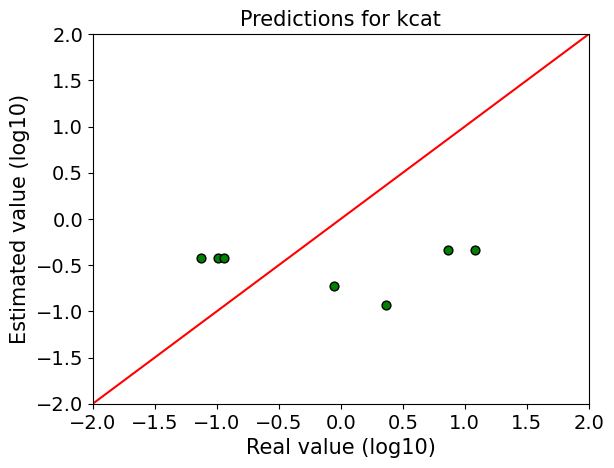

In [16]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

plt.scatter(val_Y,y_val_pred,c='green', edgecolors='black',s=40)
    
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Real value (log10)', fontsize=15)
plt.ylabel('Estimated value (log10)', fontsize=15)
plt.title('Predictions for kcat', fontsize=15)
plt.axline((1, 1), slope=1, c='red')
plt.show()

## 5. Training a model with main substrate information (MACCS) + Temperature + pH:

#### (a) Creating input matrices:

In [17]:
train_X = np.array(list(data_train['GNN FP']))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test['GNN FP']))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [18]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.quniform("learning_rate", 0.01, 0.2, 0.1),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.quniform("num_rounds", 100, 1000, 250)
#     }

# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 10, trials=trials, return_argmin=False)

# print(best)
# param = best
# param["random_state"] = 42

In [19]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 5.0, 'max_depth': 4.0, 'min_child_weight': 3.0, 'num_rounds': 250.0, 'reg_alpha': 0.2, 'reg_lambda': 0.2}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4.0, 'max_depth': 4.0, 'min_child_weight': 5.0, 'num_rounds': 250.0, 'reg_alpha': 1.0, 'reg_lambda': 0.4}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 3.0, 'min_child_weight': 6.0, 'num_rounds': 500.0, 'reg_alpha': 0.8, 'reg_lambda': 0.4}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 7.0, 'min_child_weight': 2.0, 'num_rounds': 250.0, 'reg_alpha': 0.6, 'reg_lambda': 1.0}
else:
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 5.0, 'max_depth': 10.0, 'min_child_weight': 5.0, 'num_rounds': 250.0, 'reg_alpha': 0.2, 'reg_lambda': 0.8}

#### (c) Training and validating model:

In [20]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [21]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_gnn_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_gnn_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_gnn_fp.npy"), np.array(R2))

[0.3976283419413719, -0.2747263962471343, -0.09539156076201312, 0.21709760288710658, -0.22356285463677522]
[3.252244413183113, 16.761263678172384, 131.8501108388563, 27.927157174317756, 41.970462606515895]
[0.10648471838899376, -2.04057599617074, -0.0563860109567913, -0.039381459176460964, -0.0771049795197305]
[2.5580056769317228, 12.441259793342475, 31.67566944861314, 11.989679131689845, 11.385007615229503]
[2.381245511666192, 9.366303276239236, 0.8149169982920881, 2.8002763263589268, 0.8773225522077258]


In [22]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate kcat"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", "y_test_pred_xgboost_gnn_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_gnn_fp.npy"), test_Y)

0.34 52.6734492479 -0.007 9.4807426965 0.0555298035


In [23]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate kcat"] = [10**x for x in data_test["Estimate kcat"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [24]:
train_X = np.array(list(data_train["GNN FP"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["GNN FP"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [25]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.9595335147778007, 2.736109141413954e-20) 47.273879862657445 0.1888459042010805


In [26]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

1280
167
f0: 278.0
f1: 113.0
f2: 21.0
f3: 17.0
f4: 109.0
f5: 53.0
f6: 96.0
f7: 133.0
f8: 1.0
f9: 2.0
f10: 25.0
f11: 93.0
f12: 208.0
f14: 105.0
f16: 107.0
f18: 146.0
f19: 71.0
f20: 55.0
f21: 22.0
f23: 48.0
f24: 65.0
f26: 3.0
f28: 23.0
f29: 13.0
f30: 198.0
f31: 50.0
f32: 25.0
f33: 1.0
f34: 69.0
f35: 75.0
f36: 36.0
f37: 37.0
f38: 209.0
f40: 5.0
f41: 1.0
f43: 15.0
f45: 62.0
f46: 2.0
f47: 82.0
f49: 17.0
f50: 326.0
f51: 1048.0


#### (e) Validating model:

In [27]:
val_X = np.array(list(data_val["GNN FP"]))
val_X = np.concatenate([val_X, np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate kcat"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

(-0.23247452210143305, 0.6159165835056633) 5.2786281899980025 -0.5092198988276766 3.75441059182537 2.541412223574588


## 6. Training a model with reaction information (diff-fp) + Temperature + pH:

#### (a) Creating input matrices:

In [28]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [29]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.quniform("learning_rate", 0.01, 0.2, 0.1),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.quniform("num_rounds", 100, 1000, 250)
#     }

# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 10, trials=trials, return_argmin=False)

# print(best)
# param = best
# param["random_state"] = 42

In [30]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 3.0, 'max_depth': 6.0, 'min_child_weight': 6.0, 'num_rounds': 500.0, 'reg_alpha': 0.2, 'reg_lambda': 0.8}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4.0, 'max_depth': 8.0, 'min_child_weight': 4.0, 'num_rounds': 750.0, 'reg_alpha': 0.6, 'reg_lambda': 0.0}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 4.0, 'num_rounds': 750.0, 'reg_alpha': 1.0, 'reg_lambda': 1.0}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4.0, 'max_depth': 9.0, 'min_child_weight': 6.0, 'num_rounds': 250.0, 'reg_alpha': 0.6, 'reg_lambda': 1.0}
else:
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 2.0, 'max_depth': 6.0, 'min_child_weight': 4.0, 'num_rounds': 750.0, 'reg_alpha': 0.2, 'reg_lambda': 0.2}

#### (c) Training and validating model:

In [31]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [32]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_diff_fp.npy"), np.array(R2))

[0.3248067421259059, -0.2771757429665835, 0.049789717656399536, 0.6716857447267276, 0.13738833742861664]
[3.6164139940683855, 13.885058279713633, 131.3516083688686, 25.02706997213583, 41.06341572318188]
[-0.1048209837627816, -1.0865930675570725, -0.048413085947547785, 0.165278648271601, -0.03105222831641785]
[2.7096473527994633, 10.279173516414994, 31.26734221358989, 10.90368039335311, 11.427387295905364]
[2.6688083710327133, 8.037275630371614, 0.5651459843250255, 3.5998748250133983, 2.0642603800568993]


In [33]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate kcat"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", "y_test_pred_xgboost_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_diff_fp.npy"), test_Y)

0.994 25.3123466259 0.767 5.1765870128 0.0436218629


In [34]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate kcat"] = [10**x for x in data_test["Estimate kcat"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [35]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [36]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.9989857741451618, 2.2463549885395846e-47) 14.762389079555492 0.9209004220979533


In [37]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

1280
167
f4: 3.0
f5: 2.0
f6: 3.0
f7: 22.0
f10: 8.0
f11: 3.0
f13: 3.0
f23: 1.0
f28: 5.0
f29: 5.0
f36: 7.0
f43: 8.0
f52: 4.0
f60: 2.0
f61: 4.0
f71: 5.0
f75: 23.0
f88: 1.0
f92: 1.0
f94: 7.0
f95: 21.0
f106: 3.0
f111: 1.0
f115: 3.0
f116: 8.0
f124: 11.0
f125: 5.0
f137: 9.0
f138: 5.0
f139: 7.0
f146: 4.0
f158: 5.0
f159: 2.0
f169: 12.0
f178: 3.0
f190: 4.0
f191: 17.0
f195: 4.0
f201: 4.0
f210: 1.0
f216: 5.0
f224: 1.0
f235: 1.0
f246: 19.0
f254: 7.0
f270: 1.0
f311: 4.0
f312: 11.0
f314: 3.0
f334: 15.0
f374: 9.0
f377: 8.0
f477: 6.0
f522: 1.0
f554: 1.0
f563: 13.0
f571: 6.0
f585: 6.0
f648: 2.0
f682: 1.0
f704: 8.0
f706: 3.0
f711: 2.0
f728: 4.0
f760: 4.0
f772: 2.0
f776: 6.0
f783: 2.0
f798: 16.0
f808: 15.0
f818: 2.0
f823: 12.0
f836: 3.0
f837: 7.0
f844: 11.0
f883: 1.0
f888: 1.0
f901: 1.0
f909: 4.0
f910: 2.0
f936: 4.0
f953: 1.0
f1010: 5.0
f1018: 4.0
f1019: 2.0
f1024: 1.0
f1032: 3.0
f1049: 3.0
f1051: 11.0
f1074: 1.0
f1088: 9.0
f1089: 2.0
f1096: 10.0
f1099: 6.0
f1104: 1.0
f1112: 20.0
f1113: 2.0
f1115: 7.0
f11

#### (e) Validating model:

In [38]:
val_X = np.array(list(data_val["difference_fp"]))
val_X = np.concatenate([val_X, np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate kcat"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

(-0.9177927831904111, 0.0035590115524802225) 5.2691477491272325 -0.5038036350496571 3.9671044018636157 2.485071693501408


## 7. Training a model with reaction and main substrate information (diff-fp/MACCS) + Temperature + pH:

#### (a) Creating input matrices:

In [39]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [40]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.quniform("learning_rate", 0.01, 0.2, 0.1),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.quniform("num_rounds", 100, 1000, 250)
#     }

# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 10, trials=trials, return_argmin=False)

# print(best)
# param = best
# param["random_state"] = 42

In [41]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 1.0, 'max_depth': 9.0, 'min_child_weight': 4.0, 'num_rounds': 250.0, 'reg_alpha': 0.2, 'reg_lambda': 1.0}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 6.0, 'min_child_weight': 4.0, 'num_rounds': 250.0, 'reg_alpha': 0.6, 'reg_lambda': 0.2}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 4.0, 'num_rounds': 250.0, 'reg_alpha': 0.8, 'reg_lambda': 0.4}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 5.0, 'max_depth': 4.0, 'min_child_weight': 3.0, 'num_rounds': 500.0, 'reg_alpha': 0.2, 'reg_lambda': 0.0}
else:
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 3.0, 'num_rounds': 250.0, 'reg_alpha': 1.0, 'reg_lambda': 0.6}

#### (c) Training and validating model:

In [42]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [43]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_gnn_fp_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_gnn_fp_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_gnn_fp_diff_fp.npy"), np.array(R2))

[0.5128948932591937, -0.24905401469442967, -0.008160032042855397, 0.4898800480009707, 0.16965654334254177]
[3.0000475571681227, 13.762051393234385, 131.59437009600347, 27.45320474258864, 40.522845821461964]
[0.2396878854055986, -1.0497868229983252, -0.05229198426224935, -0.004402083608861851, -0.004084807278497138]
[2.3289325043433995, 10.637072674350366, 31.377590022636575, 11.210092428726727, 12.07913784107151]
[2.5722755713513012, 9.570142460100515, 0.361462625966383, 2.3138521667546317, 2.8979872690227144]


In [44]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate kcat"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", "y_test_pred_xgboost_gnn_fp_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_gnn_fp_diff_fp.npy"), test_Y)

0.988 37.0807953997 0.501 7.1784081374 0.0480633391


In [45]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate kcat"] = [10**x for x in data_test["Estimate kcat"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [46]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X,  np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [47]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.9982589919427571, 2.1797960008110156e-43) 26.005926993848263 0.7545259719637842


In [48]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

1280
167
f4: 3.0
f6: 1.0
f7: 2.0
f11: 6.0
f23: 2.0
f28: 8.0
f29: 3.0
f52: 1.0
f61: 3.0
f74: 6.0
f75: 12.0
f94: 3.0
f116: 5.0
f124: 1.0
f125: 3.0
f134: 1.0
f138: 6.0
f157: 4.0
f158: 6.0
f178: 2.0
f181: 5.0
f190: 3.0
f191: 7.0
f195: 3.0
f200: 1.0
f201: 4.0
f202: 1.0
f232: 1.0
f233: 2.0
f235: 4.0
f254: 7.0
f311: 2.0
f312: 2.0
f377: 2.0
f477: 1.0
f571: 2.0
f585: 4.0
f648: 5.0
f728: 2.0
f756: 9.0
f760: 1.0
f775: 1.0
f823: 18.0
f844: 9.0
f847: 2.0
f909: 3.0
f910: 10.0
f936: 1.0
f944: 2.0
f953: 2.0
f1038: 5.0
f1091: 16.0
f1096: 1.0
f1099: 3.0
f1105: 7.0
f1115: 2.0
f1162: 17.0
f1214: 6.0
f1277: 2.0
f1285: 1.0
f1307: 1.0
f1310: 7.0
f1353: 1.0
f1372: 3.0
f1393: 2.0
f1402: 1.0
f1427: 3.0
f1432: 2.0
f1433: 1.0
f1483: 6.0
f1503: 1.0
f1521: 2.0
f1669: 4.0
f1724: 1.0
f1735: 34.0
f1741: 8.0
f1757: 1.0
f1809: 1.0
f1844: 4.0
f1851: 11.0
f1886: 1.0
f1909: 2.0
f1910: 10.0
f1974: 9.0
f2048: 7.0
f2050: 7.0
f2052: 9.0
f2053: 2.0
f2054: 15.0
f2055: 18.0
f2056: 3.0
f2057: 4.0
f2058: 4.0
f2059: 10.0
f2060: 17.0

#### (e) Validating model:

In [49]:
val_X = np.array(list(data_val["difference_fp"]))
val_X = np.concatenate([val_X,  np.array(list(data_val["GNN FP"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate kcat"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

(-0.24579331151146433, 0.5952178526652093) 5.17578122933117 -0.4509825839103738 3.2818376121348045 1.0233204297308247


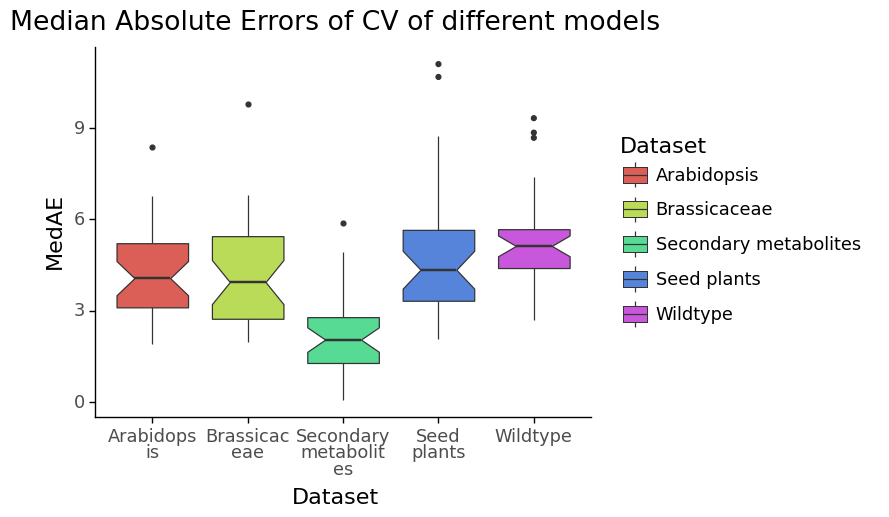

<ggplot: (-9223371905420524872)>

In [50]:
full = [2.525669465518015, 5.422820263237481, 4.341285384594962, 2.8865603011668863, 8.229403635384902, 2.2035661523559593, 5.137685122841545, 4.852996973185741, 3.5824584682125487, 5.58177709588594, 2.7612314706201486, 5.403051268476578, 5.722111299056111, 3.123713345127185, 8.124649977472929, 2.0757106540395167, 3.4507220911344167, 5.404674409253394, 2.5250000000000004, 7.480400743181096, 3.800808960859681, 4.843634240030964, 5.361125470814857, 3.293538533741149, 10.679580637579177, 3.599387615594949, 4.039850198373111, 6.977396262375776, 3.166048749701311, 11.10166175941649, 3.4402608170948, 4.103841637601738, 7.213938206506146, 3.3479110381246526, 8.726135950922561]
brassicaceae = [3.7783770876904645, 3.8117829754107633, 3.1841935876431964, 4.806384329472891, 5.440362807753033, 2.744156619496419, 3.160013143440326, 2.4820676846092686, 9.775129809484595, 5.654861729678262, 2.3704902132277472, 4.038346480332529, 2.3213950451404504, 4.446020284169857, 5.641931682200154, 2.4296263002033562, 3.329071977989498, 2.3109565254167466, 6.791513988308128, 3.935383361570171, 2.5601487239139584, 6.033827612684164, 2.13548385678143, 6.137836922260788, 5.448842600390276, 1.972462161966018, 4.673914807454723, 3.092746723265249, 4.557241114022569, 6.544629633611905, 3.1484029844887713, 6.027642629989661, 2.7118844874612, 4.449951621491173, 4.655173374175075]
arabidopsis = [2.24668312785181, 3.6112459691218044, 3.2415971186548123, 6.748887496584656, 4.459347287617216, 2.2985642942947564, 5.027656069240425, 2.9136483235316417, 5.39789400133967, 5.679426333266356, 2.5058325022835204, 4.455721442803813, 2.9653575153861604, 6.714638336910071, 5.631901734801129, 1.8854369707987129, 4.850825889358308, 2.482107034607667, 5.882385268827873, 3.9988266514110298, 4.798130247139667, 8.38772992461108, 4.167792102118241, 5.815417595660433, 4.0976707456788555, 2.9399806124229184, 3.9553012286390383, 2.837514198583655, 4.642950353668862, 4.064687158406158, 3.4515677009145516, 3.4585001935624513, 3.3225476011856507, 5.874393958795218, 3.6013763861563657]
wildtype = [5.365710954412155, 4.578590781519923, 4.830737255232654, 8.678460805832767, 3.3131608324651944, 5.719823206516246, 4.185032586168758, 4.772984823683941, 5.628282725920863, 3.504590890476882, 4.872780724623036, 4.7095972707244655, 5.263453505960671, 7.381359008124431, 2.757133624736851, 5.148177517109062, 5.124777229826302, 4.742465198401106, 6.290174606284843, 2.6791175515135306, 3.6983310152591837, 4.461224235145593, 5.795320643134783, 9.324213956079355, 5.146251299299353, 7.372048665276725, 3.917165578353641, 5.130408459595212, 8.84872050820257, 5.491358744500391, 5.5391225455290085, 4.331558064989592, 3.9640085481752925, 6.698271654560862, 4.983905842387605]
secondary = [2.7565780601633847, 2.0853803944798384, 4.223135603516898, 0.0667648218874211, 2.989474871659037, 1.4464873636827096, 2.805975873505879, 4.825763180013089, 0.07543974847736926, 1.7752381196230713, 2.493359504918104, 1.8241223663097688, 5.86409871016386, 0.08400883629944075, 2.414603487573231, 2.0350544136591324, 1.4791762187363218, 4.938123990411306, 0.058228001256824875, 1.7841047158716599, 1.102549976135132, 2.8082566742201047, 2.628940969153679, 0.5406062911879592, 2.044051424097024, 1.9770485890286724, 3.5096851769582975, 2.811898194311289, 0.053504035842008885, 2.049503930268175, 1.0481559654340036, 2.145990006559398, 2.6648215775893447, 0.06720040895536844, 1.9924519902396922]

data_frame = pd.DataFrame({"Seed plants": full, "Brassicaceae": brassicaceae, "Arabidopsis" : arabidopsis,
                             "Wildtype" : wildtype, "Secondary metabolites" : secondary}).melt()
from plotnine import (
    ggplot,
    aes,
    geom_boxplot,
    labs,
    theme_classic,
    scale_x_discrete
)

import textwrap

(
    ggplot(data_frame, aes(x = "variable", y="value"))
    + geom_boxplot(aes(fill="variable"), notch=True) 
    + scale_x_discrete(labels= [textwrap.fill(label, width=9) for label in ["Arabidopsis","Brassicaceae", "Secondary metabolites", "Seed plants", "Wildtype"]])
    + labs(title="Median Absolute Errors of CV of different models", x="Dataset", y="MedAE", fill="Dataset")
    + theme_classic(base_size=16)
)
